# Introduction

This notebook demonstrates how transfer learning can be applied with a pre-trained model. In this example, the chosen pre-trained model is Xception, and the chosen image dataset is CIFAR-10. The flow of this demo follows the guide provided by TensorFlow [[1](https://keras.io/guides/transfer_learning/#an-endtoend-example-finetuning-an-image-classification-model-on-a-cats-vs-dogs-dataset)].

## Xception

According to Chollet (2016) [[2](https://arxiv.org/abs/1610.02357)], "We present an interpretation of Inception modules in convolutional neural networks as being an intermediate step in-between regular convolution and the depthwise separable convolution operation (a depthwise convolution followed by a pointwise convolution). In this light, a depthwise separable convolution can be understood as an Inception module with a maximally large number of towers. This observation leads us to propose a novel deep convolutional neural network architecture inspired by Inception, where Inception modules have been replaced with depthwise separable convolutions. We show that this architecture, dubbed Xception, slightly outperforms Inception V3 on the ImageNet dataset (which Inception V3 was designed for), and significantly outperforms Inception V3 on a larger image classification dataset comprising 350 million images and 17,000 classes. Since the Xception architecture has the same number of parameters as Inception V3, the performance gains are not due to increased capacity but rather to a more efficient use of model parameters."

## CIFAR-10
The CIFAR-10 dataset [[3](https://www.cs.toronto.edu/~kriz/cifar.html)] consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images.

The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Why this?

To solve the issue in the previous model (CNN_class_exercises file), we use this. We have multiple models in Deep Learning, and there has been a consistent observation across images, where they exhibit certain characteristics that overlap with each other. A concept called Transfer Learning involves leveraging pre-trained models, which were initially trained on large datasets, and fine-tuning them for our specific use case.

Models like Timm (Pytorch) or VGG16 (Keras) are examples of architectures that perform exceptionally well with image data. Essentially, instead of experimenting with what kind of architectures work for our model, we can examine established ones like VGG, AlexNet, ResNet, InceptionNet, GoogLeNet, etc., to understand why they are effective and implement them in our use case.

In this scenario, we've employed the same dataset, but our approach involves utilizing pre-trained models.

# Load Required Modules

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Import keras functions

import tensorflow as tf
print(tf.__version__)

from keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG19,Xception
from tensorflow.keras.layers import Input,Flatten,Dense,BatchNormalization,Activation,Dropout,GlobalAveragePooling2D,MaxPooling2D,RandomFlip,RandomZoom,RandomRotation

2.15.0


In [3]:
#Import the dataset

from keras.datasets import cifar10

# Load CIFAR-10

In [4]:
(x_train, y_train), (x_val, y_val) = cifar10.load_data()

# xception.preprocess_input(): the inputs pixel values are scaled between -1 and 1
#x_train = tf.keras.applications.xception.preprocess_input(x_train)
#x_val = tf.keras.applications.xception.preprocess_input(x_val)

#One hot encoding - y variables
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)

print((x_train.shape, y_train.shape))
print((x_val.shape, y_val.shape))

((50000, 32, 32, 3), (50000, 10))
((10000, 32, 32, 3), (10000, 10))


# Xception

In [5]:
#Called the model called Xception and it is a pretty deep layer of NN, that works well on images.
base_model = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3), classes=y_train.shape[1])
#Imagenet is a huge dataset with around 1000 classes.

83683744/83683744 [==============================] - 3s 0us/step


In [6]:
base_model.summary()
#There are around 20M params that we need to calculate. But the initial layers of the NN don't change as much when we're training. Therefore the first 100 or 200 layers don't change as much, they change minimally.
# Now, what we do is, freeze the first few number of layers and we use that.

#Most images are very similar mathematically, & transfer learning is also used in large language models. We're just fine tuning the final few layers for our use case.

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [7]:
# freeze all layers
base_model.trainable = False

# to freeze only some of the layers
# index 0 is the input layer
#for layer in base_model.layers[:12]:
#    layer.trainable = False

In [8]:
#uncomment to see the architecture of Xception

#base_model.summary()

In [9]:
#Doing some augmentation
data_augmentation = Sequential(
    [RandomFlip("horizontal"), 
     RandomRotation(0.1),
     RandomZoom(0.1)]
)

Consider the image resolution that the imagenet was trained on.

The original image resolution of CIFAR-20 is 32x32, which is too low for Xception (min. 71x71)

In [10]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224,224)))(inputs)
x = data_augmentation(x)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(10, activation=('softmax'))(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
#Check the architecture of the final model

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        208614

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, verbose=1)

Epoch 1/20
 679/1563 [============>.................] - ETA: 22:48 - loss: 0.8504 - accuracy: 0.7138

## Cross Validation

Source: https://www.kaggle.com/ryanholbrook/the-convolutional-classifier

In [ ]:
def plot_history(history):
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
    
    return
    
plot_history(history)

#Here, both are starting with a high accuracy, hence we know that the initial weights that are associated with images are usually very similar and all we have to do, is to train the last few layers.


# Fine Tuning

In [ ]:
# unfreeze the layers of the pre-trained model

base_model.trainable = True

In [ ]:
# Use a small learning rate

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
epochs = 10
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, verbose=1)

Epoch 1/10
1563/1563 [==============================] - 669s 425ms/step - loss: 0.3341 - accuracy: 0.8860 - val_loss: 0.1716 - val_accuracy: 0.9425
Epoch 2/10
1563/1563 [==============================] - 642s 411ms/step - loss: 0.2195 - accuracy: 0.9254 - val_loss: 0.1332 - val_accuracy: 0.9535
Epoch 3/10
1563/1563 [==============================] - 642s 411ms/step - loss: 0.1749 - accuracy: 0.9401 - val_loss: 0.1271 - val_accuracy: 0.9562
Epoch 4/10
1563/1563 [==============================] - 641s 410ms/step - loss: 0.1426 - accuracy: 0.9511 - val_loss: 0.1174 - val_accuracy: 0.9602
Epoch 5/10
1563/1563 [==============================] - 641s 410ms/step - loss: 0.1233 - accuracy: 0.9579 - val_loss: 0.1139 - val_accuracy: 0.9624
Epoch 6/10
1563/1563 [==============================] - 641s 410ms/step - loss: 0.1017 - accuracy: 0.9648 - val_loss: 0.1109 - val_accuracy: 0.9642
Epoch 7/10
1563/1563 [==============================] - 641s 410ms/step - loss: 0.0905 - accuracy: 0.9679 - val_

## Cross Validation

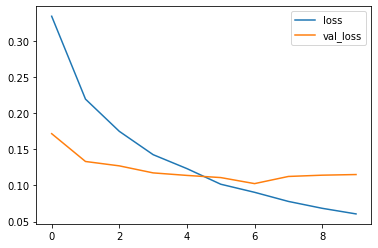

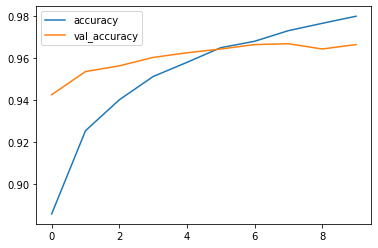

In [17]:
plot_history(history)

# Confusion Matrix

[[Text(0.5, 0, 'airplane'),
  Text(1.5, 0, 'automobile'),
  Text(2.5, 0, 'bird'),
  Text(3.5, 0, 'cat'),
  Text(4.5, 0, 'deer'),
  Text(5.5, 0, 'dog'),
  Text(6.5, 0, 'frog'),
  Text(7.5, 0, 'horse'),
  Text(8.5, 0, 'ship'),
  Text(9.5, 0, 'truck')],
 [Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'automobile'),
  Text(0, 2.5, 'bird'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'frog'),
  Text(0, 7.5, 'horse'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')]]

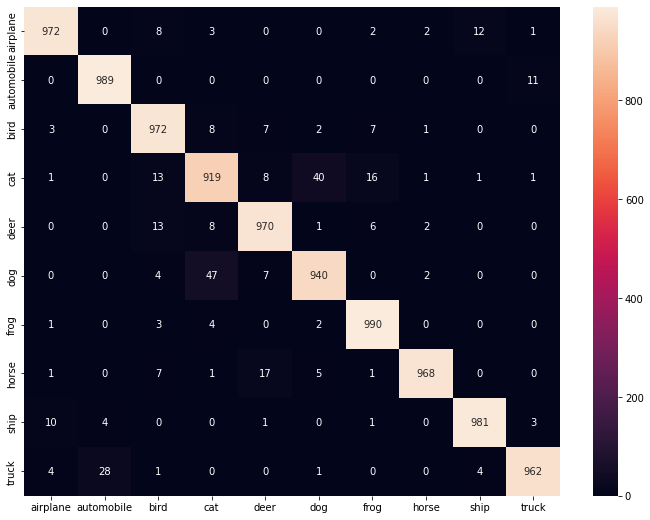

In [18]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

predictions=model.predict(x_val)

y_pred_classes = np.argmax(predictions, axis=1)
y_true = np.argmax(y_val, axis=1)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
c.set(xticklabels=class_names, yticklabels=class_names)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=class_names))


Reference: BUAN 6382.SW1.S24 course by Dr Farid Khafizov, at Naveen Jindal School to Management, UTDallas. Code along by the class's TA Harikrishna Dev.